In [1]:
import meshio
import pygalmesh
import pygmsh
import numpy as np
import copy
import glob
#from mshr import *
#from dolfin import *
from collections import Counter
import matplotlib.pyplot as plt
import os
import json
import shutil
import scipy.optimize as opt
from EnergyMinimization import *

# Initialisation

User settings: What are the continuum parameters we want? In 2D, we know that the elastic modulii are proportional to the microscopic spring constant. We also know that the continuum and microscopic momdulii are related by a lattice space: $\mu = O(1) k$, $k_c = k_d a$. Since I dont know any better, for know I will just set k to mu.

In [2]:
# Target mesh size:
target_a = 0.4
# continuum bending modulus:
kc=0.2
# continuum shear modulus:
mu=1
# Energetic penalty for volume change
B=10000
# the spring prestress values 
g0start=1.0
g0end=3
g0step=0.05

# The microscopic values
kbend=kc/target_a
khook = mu
theta0=0

Setting up the experiment:

In [3]:
# root folder for data
DataFolder=os.getcwd()+'/Data/'
# Folder for the run data
#RunFolder="kc_"+"{0:0.1f}".format(kc)+"_B_"+"{0:0.1f}".format(B)+"/"
RunFolder="Scratch/"
# Name of the run
RunName=""
# Name of the current file
ScriptName="EnergyMinimizationScript3D.ipynb"

In [4]:
path = DataFolder+RunFolder
# make the folder 
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
    
# try and clear out the folder of vtk files and log files, if there was a previous run in it
for filename in glob.glob(path+'*.vtk')+glob.glob(path+'*.log'):
    file_path = os.path.join(path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
                
#Dump all the parameters to a file in the run folder        
f=open(DataFolder+RunFolder+"Parameters.log","w+")
datadict= { 
        "a":target_a,
        "kc":kc, 
        "B":B,
        "mu":mu,
        "g0start":g0start,
        "g0end":g0end,
}
json.dump(datadict,f)
f.close()

# and for good measure, dump a copy of this code into the data file too
shutil.copyfile(ScriptName,DataFolder+RunFolder+ScriptName)

Creation of the directory /home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Scratch/ failed


'/home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Scratch/EnergyMinimizationScript3D.ipynb'

# Making the Mesh

Make the mesh, write it out to the folder. I am going to use the gmsh mesh

In [5]:
#todo: put in target a
with pygmsh.occ.Geometry() as geom:
    geom.characteristic_length_max = target_a
    ellipsoid = geom.add_ball([0.0, 0.0, 0.0], 1)
    InputMesh = geom.generate_mesh()

OutputMesh = copy.deepcopy(InputMesh)    
InputMesh.write(DataFolder+RunFolder+RunName+"InputMesh.vtk") 

/home/jackbinysh/miniconda3/lib/python3.8/site-packages/numpy/ctypeslib.py:521: RuntimeWarning: A builtin ctypes object gave a PEP3118 format string that does not match its itemsize, so a best-guess will be made of the data type. Newer versions of python may behave correctly.
  return array(obj, copy=False)


In [6]:
#InputMesh=MakeDolfinMesh3D(0.2, 100)
#OutputMesh = copy.deepcopy(InputMesh)    
#InputMesh.write(DataFolder+RunFolder+RunName+"InputMesh.vtk") 

In [7]:
InputMesh

<meshio mesh object>
  Number of points: 205
  Number of cells:
    line: 10
    triangle: 320
    tetra: 679
    vertex: 2

Make the bond lists, make the oriented boundary triangles list, make the mapping from bonds to boundary triangles

In [8]:
interiorbonds,edgebonds,boundarytris, bidxTotidx, tetras= MakeMeshData3D(InputMesh)
bonds=np.concatenate((interiorbonds,edgebonds))
orientedboundarytris=OrientTriangles(InputMesh.points,boundarytris,np.array([0,0,0]))
boundarytris=orientedboundarytris

Check out the Mesh. One of the lessons learnt is that you shouldnt have much of a spread in the intial edge lengths

0.30030964775792085

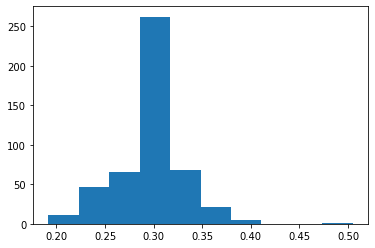

In [9]:
edgelengths= MakeBondHist(InputMesh.points,edgebonds)
np.mean(edgelengths)

# Energy Minimization

In [10]:
def mycallback(xi):
    
    counter=len(history)
    tempP = xi.reshape((-1, 3))
    
    
    print("iteration:"+"{0:0.1f}".format(counter))   
    print(Volume3D_tetras(tempP,tetras)[607])
    print((B*(Volume3D_tetras(tempP,tetras)-TargetVolumes)**2)[607])
    
    #VolumeConstraintEnergy = (B*(Volume3D_tetras(tempP,tetras)-TargetVolumes)**2).sum()
    #print(VolumeConstraintEnergy)  
    history.append(Volume3D_tetras(tempP,tetras))
    
    # stuff to screen
    #print("iteration:"+"{0:0.1f}".format(counter)+"Total Area:" + "{0:0.2f}".format(vTotalArea(tempP,triangles)))
   
    #print (B*(Volume3D_tetras(tempP,tetras)-TargetVolume)**2)

    #output for visualisation
    OutputMesh.points = tempP           
    OutputMesh.write(DataFolder+RunFolder+RunName+"TempOutput"+"Output"+"{0:0.2f}".format(g0)+"_"+str(counter)+".vtk",binary=True)

In [11]:
# initial input points. Pout changes over time
Pout_ij =InputMesh.points
N = len(Pout_ij)

# The volume constraint is simply that the target volume should be the initial volume
TargetVolumes=Volume3D_tetras(InputMesh.points,tetras)

for g0 in np.arange(g0start,g0end,g0step):
    
    print("Current g0"+"{0:0.2f}".format(g0))
    
    # make the new preferred rest lengths of all the springs
    interiorpairs=InputMesh.points[interiorbonds]
    interiorvecs = np.subtract(interiorpairs[:,0,:],interiorpairs[:,1,:])
    InteriorBondRestLengths=np.linalg.norm(interiorvecs,axis=1)

    edgepairs=InputMesh.points[edgebonds]
    edgevecs = np.subtract(edgepairs[:,0,:],edgepairs[:,1,:])
    EdgeBondRestLengths=np.linalg.norm(edgevecs,axis=1)
    # the important bit! Giving it the prestress
    EdgeBondRestLengths= g0*EdgeBondRestLengths

    r0_ij=np.concatenate((InteriorBondRestLengths,EdgeBondRestLengths))
    

    # minimize
    history=[]
    #def energy3D(P,bondlist,orientedboundarytris,bidxTotidx,r0_ij,khook,kbend,theta0,B,TargetArea): 
    Pout_ij = opt.minimize(energy3D, Pout_ij.ravel()
                            ,callback=mycallback
                            ,options={'gtol':1e-02,'disp': True}  
                            ,args=(bonds
                                  ,orientedboundarytris
                                  ,bidxTotidx
                                ,tetras
                                  ,r0_ij
                                  ,khook
                                  ,kbend
                                  ,theta0
                                  ,B
                                  ,TargetVolumes)
                           ).x.reshape((-1, 3))
   
    # stuff to screen
    print("Total Volume tris is:" + "{0:0.2f}".format(Volume3D(Pout_ij,orientedboundarytris,bidxTotidx)))
    print("Total Volume tetras is:" + "{0:0.2f}".format(Volume3D_tetras(Pout_ij,tetras).sum()))

    # write the output 
    OutputMesh.points= Pout_ij  
    OutputMesh.write(DataFolder+RunFolder+RunName+"g0_"+"{0:0.2f}".format(g0)+".vtk",binary=True)  


Current g01.00
iteration:0.0
0.005851805723218945
0.0012467300864595855
iteration:1.0
0.005750350666405891
0.0006332047284788155
iteration:2.0
0.005655444926751817
0.00024564247666922006
iteration:3.0
0.005649230037908347
0.0002265475524703425
iteration:4.0
0.005644424723450878
0.00021231302801492062
iteration:5.0
0.005662728498578446
0.00026900404408173776
iteration:6.0
0.005687876632292098
0.00035782096249869914
iteration:7.0
0.005669455909469799
0.0002915243390278144
iteration:8.0
0.0056461035973683835
0.00021723377688997398
iteration:9.0
0.005631981575786191
0.00017759961283419
iteration:10.0
0.005633519799345579
0.00018172314769649174
iteration:11.0
0.005636710512254824
0.00019042741792089978
iteration:12.0
0.005637213506611248
0.00019181816651684617
iteration:13.0
0.005628543819576123
0.00016855503942707594
iteration:14.0
0.00562108009945137
0.0001497320017458274
iteration:15.0
0.005619784155386474
0.00014657723180998237
iteration:16.0
0.005624217285791492
0.00015750805903906291


iteration:7.0
0.005679223376354853
0.0003258324828242891
iteration:8.0
0.005676893092051826
0.0003174740716654658
iteration:9.0
0.005677359561573697
0.0003191385399288664
iteration:10.0
0.005677035490483259
0.00031798171985271466
iteration:11.0
0.005678371527179919
0.00032276442227567955
iteration:12.0
0.005678311086378736
0.00032254728720366413
iteration:13.0
0.005679914934754448
0.00032833390604903104
iteration:14.0
0.005680955406556827
0.0003321153988402428
iteration:15.0
0.005681861203852477
0.0003354250595887804
iteration:16.0
0.005681969960758815
0.00033582354600564295
iteration:17.0
0.005681043689272687
0.00033243725021376945
iteration:18.0
0.005679265691529531
0.00032598526553942003
iteration:19.0
0.0056812958081764635
0.0003333572556802318
iteration:20.0
0.005684245276621327
0.00034421457177692964
iteration:21.0
0.005684220794987601
0.0003441237361196796
iteration:22.0
0.005683889937724325
0.0003428973124621158
iteration:23.0
0.005683267452314326
0.00034059581428696166
iterati

iteration:6.0
0.0057481592212729445
0.0006222238407823418
iteration:7.0
0.005745920081601001
0.0006111031723932766
iteration:8.0
0.005744695720139063
0.0006050647972409484
iteration:9.0
0.005743313855149056
0.000598285651805667
iteration:10.0
0.0057440651621668585
0.0006019666720887438
iteration:11.0
0.005746241524399782
0.0006126934510572625
iteration:12.0
0.005747054682339784
0.000616725625333582
iteration:13.0
0.005747433136930292
0.0006186067629302718
iteration:14.0
0.005748713703327783
0.0006249931613854458
iteration:15.0
0.005749524934561128
0.000629055876322458
iteration:16.0
0.00575097575946647
0.0006363545491811363
iteration:17.0
0.005748106530809698
0.0006219610019886064
iteration:18.0
0.0057469836938945406
0.0006163730908692245
iteration:19.0
0.005749762695530317
0.0006302490975498322
iteration:20.0
0.005752146532677561
0.0006422750574043406
iteration:21.0
0.005751400782998264
0.0006385006902055944
iteration:22.0
0.005751978342184875
0.0006414228450369045
iteration:23.0
0.00

iteration:41.0
0.005777003585443187
0.0007744449724069857
iteration:42.0
0.005776439572650505
0.0007713089878678515
iteration:43.0
0.005777713935334685
0.000778403662696692
iteration:44.0
0.005776546348185561
0.0007719021855231221
iteration:45.0
0.005775162444503173
0.0007642315028670604
iteration:46.0
0.0057747602195023255
0.0007620092398161775
iteration:47.0
0.005774567385951029
0.000760944996338097
iteration:48.0
0.005774346722338948
0.0007597280718982714
iteration:49.0
0.00577355410295495
0.0007553649345601232
iteration:50.0
0.005774009861770486
0.0007578722179539404
iteration:51.0
0.005773957686637496
0.0007575849743300437
Optimization terminated successfully.
         Current function value: 126.381943
         Iterations: 52
         Function evaluations: 35112
         Gradient evaluations: 57
Total Volume tris is:4.14
Total Volume tetras is:4.14
Current g01.60
iteration:0.0
0.005766400468484579
0.0007165547199733394
iteration:1.0
0.005776408842845163
0.0007711383089136067
iter

iteration:3.0
0.005799746074288251
0.0009061966490795734
iteration:4.0
0.005797633017172776
0.0008935193851160735
iteration:5.0
0.005798132858884016
0.0008965101166875988
iteration:6.0
0.005800731537920653
0.0009121394625835335
iteration:7.0
0.005808886156499181
0.0009620610224597168
iteration:8.0
0.005793871967613134
0.0008711759358616216
iteration:9.0
0.005787194660379042
0.000832204734568938
iteration:10.0
0.005788848697744122
0.0008417752133611056
iteration:11.0
0.005793128705686264
0.0008667938825712369
iteration:12.0
0.005794994983867176
0.00087781786736325
iteration:13.0
0.005800572233316354
0.0009111774640881807
iteration:14.0
0.0057978932248943195
0.000895075677350414
iteration:15.0
0.005801532987825123
0.0009169869071733903
iteration:16.0
0.005805988832132537
0.0009441716424708243
iteration:17.0
0.005802109311685622
0.0009204806524817465
iteration:18.0
0.005795119477021083
0.0008785557187644121
iteration:19.0
0.005794789107511788
0.0008765983506415006
iteration:20.0
0.0058030

iteration:70.0
0.00572982280871573
0.0005341078640692167
iteration:71.0
0.005733196288718749
0.0005498144143733921
iteration:72.0
0.005730752517492776
0.0005384137654962566
iteration:73.0
0.005732362239545719
0.000545909993439942
iteration:74.0
0.00573216221266655
0.0005449756792686675
iteration:75.0
0.005736796084893292
0.0005668256915053778
iteration:76.0
0.0057291649098148495
0.000531071281847009
iteration:77.0
0.005735037311751884
0.0005584820144826288
iteration:78.0
0.0057314160305760664
0.0005414973656228783
iteration:79.0
0.005732682696632422
0.0005474084981860103
iteration:80.0
0.005724016354345592
0.000507606682526421
iteration:81.0
0.0057283589978708955
0.0005273633312368375
iteration:82.0
0.005724416088158764
0.0005094094912192834
iteration:83.0
0.005719247414842762
0.00048634514656772693
iteration:84.0
0.005717786596265618
0.00047992333158354024
iteration:85.0
0.005723991078267339
0.000507492794257883
iteration:86.0
0.005720979138409687
0.0004940131563729972
iteration:87.0


iteration:43.0
0.005635002609058199
0.00018574293015127317
iteration:44.0
0.005673294947777832
0.0003047813335675627
iteration:45.0
0.005621776020493984
0.00015143997276963246
iteration:46.0
0.0056446221420334486
0.00021288873361674819
iteration:47.0
0.005719624349052201
0.00048800909105494025
iteration:48.0
0.005687541420448353
0.00035655390225433956
iteration:49.0
0.0056665099906874
0.0002815513505463319
iteration:50.0
0.005673817068783561
0.00030660709608730654
iteration:51.0
0.005661846528458566
0.0002661187239479567
iteration:52.0
0.0056991842528194454
0.0004018789283753268
iteration:53.0
0.0056877408135773
0.0003573073133632046
iteration:54.0
0.005673190144700504
0.0003044155132380111
iteration:55.0
0.005719577776252971
0.0004878033454761519
iteration:56.0
0.005700906141400186
0.00040881228927560406
iteration:57.0
0.005690502996424599
0.0003678260831779154
iteration:58.0
0.005714715151894413
0.0004665603492287703
iteration:59.0
0.005695532061424945
0.0003873692769850519
iteration

iteration:182.0
0.005686657727893195
0.0003532244225961174
iteration:183.0
0.005685657203537703
0.00034947360897391767
iteration:184.0
0.005685856941090073
0.0003502207952043537
iteration:185.0
0.005686036332449722
0.0003508925497072119
iteration:186.0
0.005685497269082164
0.00034887589500069656
Optimization terminated successfully.
         Current function value: 156.272635
         Iterations: 187
         Function evaluations: 117656
         Gradient evaluations: 191
Total Volume tris is:4.16
Total Volume tetras is:4.16
Current g01.85
iteration:0.0
0.00566302095694965
0.00026996424139811355
iteration:1.0
0.0056929099647917356
0.00037711656753641347
iteration:2.0
0.005734600486418283
0.0005564192918137481
iteration:3.0
0.005741493587113803
0.0005894140785998876
iteration:4.0
0.005736843053564335
0.000567049360542353
iteration:5.0
0.005717378626818911
0.0004781375061956416
iteration:6.0
0.00569901114231816
0.00040118516163683177
iteration:7.0
0.005712192097046601
0.00045572440626459

iteration:131.0
0.0056606882397781805
0.0002623530738641083
iteration:132.0
0.005659405724290482
0.0002582148603742739
iteration:133.0
0.0056594942481471315
0.00025849943786604565
iteration:134.0
0.005661324551333929
0.0002644184307676697
iteration:135.0
0.005660302342857537
0.0002611044640876959
iteration:136.0
0.005661486975502357
0.000264946928776034
iteration:137.0
0.005660901543899877
0.00026304451974045145
iteration:138.0
0.005661380155561481
0.00026459929717684305
iteration:139.0
0.0056602827718716
0.0002610412194734472
iteration:140.0
0.005660018884866856
0.00026018920350432144
iteration:141.0
0.005660870551863863
0.0002629439995653665
iteration:142.0
0.005661020234252307
0.0002634296600068774
iteration:143.0
0.005659988078257578
0.00026008982852344876
iteration:144.0
0.005660711512365135
0.00026242846997331064
iteration:145.0
0.005660802965946783
0.0002627248567063276
iteration:146.0
0.005660788562923171
0.0002626781676652504
iteration:147.0
0.005660547709336785
0.000261898028

iteration:89.0
0.005611530053361941
0.00012727220233042766
iteration:90.0
0.0056088517350900875
0.00012130084764902135
iteration:91.0
0.0056095403315391925
0.00012282238361514282
iteration:92.0
0.005608563955040111
0.000120667773128984
iteration:93.0
0.005612173290978444
0.00012872767668324793
iteration:94.0
0.0056125694164519645
0.0001296281196589988
iteration:95.0
0.005613309645743167
0.00013131916548091258
iteration:96.0
0.005611903679314057
0.00012811661039750094
iteration:97.0
0.005613943182052963
0.00013277517564288954
iteration:98.0
0.005609140021142455
0.00012193669601941709
iteration:99.0
0.005609887174410094
0.00012359236564521273
iteration:100.0
0.005612108180348925
0.00012857997235472143
iteration:101.0
0.005611572915547488
0.0001273689306361809
iteration:102.0
0.005609112193064719
0.00012187524548153477
iteration:103.0
0.005611330378256262
0.00012682207416161737
iteration:104.0
0.005613812157374477
0.00013247339279363204
iteration:105.0
0.005615234042302423
0.0001357667066

iteration:76.0
0.005567458557374002
4.725666911368449e-05
iteration:77.0
0.005570416524015334
5.14109835670392e-05
iteration:78.0
0.005559833606801446
3.735475411858631e-05
iteration:79.0
0.005564011396712108
4.263610144392883e-05
iteration:80.0
0.005559010057101126
3.6354853423706796e-05
iteration:81.0
0.00555776563794845
3.486969450504536e-05
iteration:82.0
0.005559394089750805
3.681943309954431e-05
iteration:83.0
0.005560429784192459
3.80870581770853e-05
iteration:84.0
0.005558200975863912
3.5385728710021694e-05
iteration:85.0
0.005557439051324585
3.448505858768953e-05
iteration:86.0
0.005557652332151292
3.473600745599098e-05
iteration:87.0
0.005552191943171002
2.8597758513716268e-05
iteration:88.0
0.005551833751460583
2.8215942080904552e-05
iteration:89.0
0.005552435027226514
2.8858336911300704e-05
iteration:90.0
0.005548537913126529
2.4823155921408257e-05
iteration:91.0
0.005546657525547691
2.2984789428379226e-05
iteration:92.0
0.005547070057784109
2.3382047416269598e-05
iteration

iteration:63.0
0.005479778299230753
3.586013271021966e-06
iteration:64.0
0.005480623208165778
3.273155027819894e-06
iteration:65.0
0.005477483867477698
4.507640053168539e-06
iteration:66.0
0.005478419622720742
4.119052230656069e-06
iteration:67.0
0.005475513884699572
5.382950482731013e-06
iteration:68.0
0.005476357472214626
4.998622258818331e-06
iteration:69.0
0.005474909614208768
5.666997756309236e-06
iteration:70.0
0.005480286341620381
3.3961806855356746e-06
iteration:71.0
0.005483240876225692
2.3945070559790007e-06
iteration:72.0
0.005486083492081428
1.5955678735132482e-06
iteration:73.0
0.005485471740103332
1.7538581468044048e-06
iteration:74.0
0.00548529787527528
1.800211425761743e-06
iteration:75.0
0.005482334923762203
2.683092253152185e-06
iteration:76.0
0.0054846650010333215
1.9740446759819886e-06
iteration:77.0
0.005484217812500368
2.101705055834837e-06
iteration:78.0
0.005484803088885011
1.935432478823726e-06
iteration:79.0
0.005480386115196793
3.359506228313859e-06
iteration

iteration:202.0
0.005458957577968079
1.5806582565116536e-05
iteration:203.0
0.0054607881084106046
1.4384544953865314e-05
iteration:204.0
0.005461440734273349
1.38937618246982e-05
iteration:205.0
0.005462576217186109
1.3060167589162596e-05
iteration:206.0
0.005463529585561912
1.2380183893445463e-05
Optimization terminated successfully.
         Current function value: 182.908430
         Iterations: 207
         Function evaluations: 129360
         Gradient evaluations: 210
Total Volume tris is:4.12
Total Volume tetras is:4.12
Current g02.05
iteration:0.0
0.005434693643183675
4.098743226610998e-05
iteration:1.0
0.005481489811448792
2.9670956848181224e-06
iteration:2.0
0.005513699801668521
2.2454215157671805e-06
iteration:3.0
0.005513297597459751
2.1265007636173843e-06
iteration:4.0
0.005500384256264327
2.786179264921678e-08
iteration:5.0
0.005504435957447175
3.2728541118631357e-07
iteration:6.0
0.0055026743450065875
1.5675850228190818e-07
iteration:7.0
0.005493641724214862
2.5738848154

iteration:131.0
0.005412440290229674
7.443337806360638e-05
iteration:132.0
0.005413169431851324
7.318056386668959e-05
iteration:133.0
0.005411287674701031
7.643549633135244e-05
iteration:134.0
0.005412254821591685
7.475374737160953e-05
iteration:135.0
0.0054112252443053585
7.654469784583475e-05
iteration:136.0
0.005409844206149025
7.898030629035615e-05
iteration:137.0
0.005408790777745825
8.08637852705291e-05
iteration:138.0
0.005406075244244395
8.5821375113942e-05
iteration:139.0
0.005407237635477843
8.368121219669641e-05
iteration:140.0
0.005405753036670089
8.641939836876387e-05
iteration:141.0
0.0054066928621051
8.468086939915076e-05
iteration:142.0
0.005405772732749098
8.638278249663758e-05
iteration:143.0
0.0054086233348053375
8.116520940376994e-05
iteration:144.0
0.005406423630748249
8.517709953790299e-05
iteration:145.0
0.0054067638484103465
8.455027345742783e-05
iteration:146.0
0.005406243410523121
8.551008001418556e-05
iteration:147.0
0.005406405056532885
8.52113878096888e-05


iteration:1.0
0.005306855148787815
0.00036810229772153724
iteration:2.0
0.005316097395809442
0.00033349215311885767
iteration:3.0
0.005312208198888114
0.0003478481336526451
iteration:4.0
0.0052944970880739635
0.0004170498457261226
iteration:5.0
0.005293172275996898
0.0004224784060006489
iteration:6.0
0.005301698711744362
0.00038815445835795943
iteration:7.0
0.0052946663628619176
0.0004163587531503525
iteration:8.0
0.005333843668742432
0.0002718257930032655
iteration:9.0
0.005346891548740628
0.00023050381927771166
iteration:10.0
0.005321606780551875
0.0003136734656473918
iteration:11.0
0.005285102992417576
0.00045630120139559784
iteration:12.0
0.005290477948233449
0.0004336269932076242
iteration:13.0
0.005305581643826295
0.000373005207128872
iteration:14.0
0.005312696221125945
0.00034603012528718096
iteration:15.0
0.005321037748199795
0.0003156923105679196
iteration:16.0
0.005277653965366305
0.0004886801244805856
iteration:17.0
0.005235449906389457
0.0006930854692607808
iteration:18.0
0

iteration:142.0
0.005190433967812199
0.0009503723861625046
iteration:143.0
0.005191383754561091
0.0009445253809753238
iteration:144.0
0.00519086763804457
0.0009477004201076327
iteration:145.0
0.005191489053223361
0.0009438782603233948
iteration:146.0
0.00519097003936752
0.000947070045279804
iteration:147.0
0.005190776103172844
0.0009482640793997985
iteration:148.0
0.005191524997725021
0.0009436574115213094
iteration:149.0
0.0051915403549529756
0.0009435630621201237
iteration:150.0
0.00519201765437228
0.0009406330539950782
iteration:151.0
0.005192205935438492
0.0009394785021603248
iteration:152.0
0.0051924186030062195
0.0009381752633881168
iteration:153.0
0.0051932003001963845
0.0009333927521244727
iteration:154.0
0.005193639628392849
0.0009307102571516286
iteration:155.0
0.005193541940405678
0.0009313063966996341
iteration:156.0
0.00519359150218355
0.000931003922805059
iteration:157.0
0.005194168615946303
0.000927485433189294
iteration:158.0
0.005194009071166198
0.0009284574636789032
i

iteration:110.0
0.005174440607980449
0.0010515392740192227
iteration:111.0
0.005174316681934007
0.0010523431486392904
iteration:112.0
0.005172665177743932
0.0010630853292779036
iteration:113.0
0.005173668891110642
0.001056550190960528
iteration:114.0
0.005173234020826767
0.0010593791405730589
iteration:115.0
0.0051723449355885265
0.0010651746532403565
iteration:116.0
0.005173492822468842
0.0010576951097506931
iteration:117.0
0.00517221167437584
0.0010660446804266
iteration:118.0
0.005173433580627596
0.001058080480143058
iteration:119.0
0.005172680436636122
0.0010629858284028316
iteration:120.0
0.005172705537148708
0.0010628221619742955
iteration:121.0
0.005172800202857526
0.0010622050131180883
iteration:122.0
0.00517537826644985
0.0010454668921190402
iteration:123.0
0.005171641863566448
0.0010697688305648012
iteration:124.0
0.005173807848280017
0.0010556470341098528
iteration:125.0
0.00517340425645826
0.0010582712609322688
iteration:126.0
0.005175016304783244
0.0010478089128549135
iter

iteration:99.0
0.0051739362255118
0.0010548129851200704
iteration:100.0
0.0051740615988003025
0.0010539987704666497
iteration:101.0
0.005176069390206723
0.0010410023536968382
iteration:102.0
0.005176538809949232
0.001037975432197279
iteration:103.0
0.00517837306810234
0.0010261899885536038
iteration:104.0
0.0051788257291279826
0.0010232919107813897
iteration:105.0
0.005179587493777814
0.0010184241057844586
iteration:106.0
0.0051794370259367045
0.0010193847009419975
iteration:107.0
0.005179847339994357
0.0010167662991140247
iteration:108.0
0.0051781482550036
0.0010276308355296987
iteration:109.0
0.005178626868807465
0.001024564572176975
iteration:110.0
0.005176420261005173
0.0010387394458468984
iteration:111.0
0.0051768561621131
0.0010359315726490652
iteration:112.0
0.0051754474517949215
0.0010450195366171397
iteration:113.0
0.005174984209238356
0.001048016708921812
iteration:114.0
0.005175532346013861
0.0010444707376465153
iteration:115.0
0.005174982894127294
0.0010480252237798607
iter

iteration:62.0
0.00520066634034795
0.00088833045875747
iteration:63.0
0.005202274308317974
0.000878771258117748
iteration:64.0
0.005202905336486316
0.0008750339906526113
iteration:65.0
0.005208825640778309
0.0008403588178581699
iteration:66.0
0.005198011173344071
0.0009042283409820543
iteration:67.0
0.0051953903649263715
0.0009200587734767625
iteration:68.0
0.0051997301044638304
0.000893920102471851
iteration:69.0
0.005201813728209003
0.0008815040738342087
iteration:70.0
0.005187879054711938
0.00096619029055673
iteration:71.0
0.00518242624149205
0.0010003862370594372
iteration:72.0
0.005182569126653008
0.0009994825816147027
iteration:73.0
0.005184099054149128
0.0009898323809336056
iteration:74.0
0.005185160991939106
0.000983161605298623
iteration:75.0
0.0051823939915320765
0.0010005902535019044
iteration:76.0
0.005185498465986286
0.0009810464169041687
iteration:77.0
0.005186164317053689
0.0009768797382643506
iteration:78.0
0.005187021165657511
0.000971530906615867
iteration:79.0
0.0051

iteration:39.0
0.005241052123596265
0.0006639019449283198
iteration:40.0
0.005249943911874983
0.0006188708963948857
iteration:41.0
0.005209773312941951
0.0008348733958113337
iteration:42.0
0.005210037204525834
0.0008333491062350516
iteration:43.0
0.005202449026623014
0.0008777356908304078
iteration:44.0
0.0052230096263445845
0.0007601349224265658
iteration:45.0
0.00519428376947053
0.0009267841738407075
iteration:46.0
0.005194616495073087
0.0009247594391388405
iteration:47.0
0.0051930851150590795
0.000934096700017231
iteration:48.0
0.005176026849600658
0.0010412768826500182
iteration:49.0
0.005168276947759352
0.0010918935332677653
iteration:50.0
0.00517802282183213
0.0010284351871126106
iteration:51.0
0.00519013302568584
0.000952228787238657
iteration:52.0
0.00517245944191739
0.001064427355436094
iteration:53.0
0.00516389925220236
0.001121016325535856
iteration:54.0
0.0051702026664772385
0.0010792039996109185
iteration:55.0
0.005174371494483331
0.00105198755662936
iteration:56.0
0.00518

iteration:180.0
0.005271906694094761
0.0005144203985908187
iteration:181.0
0.005272286039141961
0.0005127010649282045
iteration:182.0
0.005272815178288839
0.0005103076155150804
iteration:183.0
0.005273382240055264
0.0005077488472610112
Optimization terminated successfully.
         Current function value: 226.403767
         Iterations: 184
         Function evaluations: 114576
         Gradient evaluations: 186
Total Volume tris is:4.07
Total Volume tetras is:4.07
Current g02.35
iteration:0.0
0.0052522939141206315
0.0006072338658459433
iteration:1.0
0.005287106153856809
0.00044778333837551857
iteration:2.0
0.005308899569805276
0.00036029924514469736
iteration:3.0
0.005328426898782026
0.0002899806161587772
iteration:4.0
0.005332144138875919
0.00027745875446819854
iteration:5.0
0.005308653609457599
0.0003612335918432569
iteration:6.0
0.005279583948738613
0.00048018448767391924
iteration:7.0
0.00529200481098645
0.0004272913161737403
iteration:8.0
0.0053018614636152995
0.00038751342761801

iteration:133.0
0.0052718911625322775
0.0005144908547726821
iteration:134.0
0.005272320175442091
0.0005125464875932425
iteration:135.0
0.0052709324976784626
0.000518849007337804
iteration:136.0
0.005270133755493939
0.0005224941782336724
iteration:137.0
0.00527019671136104
0.0005222064071696001
iteration:138.0
0.0052702682399475564
0.0005218795464277483
iteration:139.0
0.005269166002694551
0.0005269277478489093
iteration:140.0
0.005267572570355253
0.0005342685562947132
iteration:141.0
0.005269198180573548
0.0005267800301601541
iteration:142.0
0.005266851984009593
0.0005376049113396415
iteration:143.0
0.005267098934905142
0.0005364603452472815
iteration:144.0
0.005264909956679597
0.0005466483150783101
iteration:145.0
0.005264746267920944
0.0005474140083971842
iteration:146.0
0.005261660873124834
0.0005619469275604649
iteration:147.0
0.005261176911869653
0.00056424377068895
iteration:148.0
0.0052610241315715345
0.0005649698271226401
iteration:149.0
0.005260511766151367
0.00056740814466744

iteration:73.0
0.005257789568167919
0.0005804509794112093
iteration:74.0
0.005254397392428732
0.0005969112808905247
iteration:75.0
0.005247423641303127
0.0006314738266645666
iteration:76.0
0.005248921555346681
0.0006239680048964003
iteration:77.0
0.005249624724407376
0.000620460007927523
iteration:78.0
0.005251918542506625
0.000609085265032501
iteration:79.0
0.005251888394250503
0.0006092340838207304
iteration:80.0
0.005251991909483378
0.0006087231845561822
iteration:81.0
0.0052470805407199865
0.0006331993685663864
iteration:82.0
0.005247929406511843
0.0006289344954006941
iteration:83.0
0.005243588788877148
0.0006508941985760478
iteration:84.0
0.005244336981916555
0.0006470821223343955
iteration:85.0
0.005243544762706461
0.0006511188626240045
iteration:86.0
0.005239955547640698
0.0006695649095730462
iteration:87.0
0.0052387772170271575
0.0006756768795630634
iteration:88.0
0.0052365004689184464
0.0006875649757333493
iteration:89.0
0.005237446547665348
0.0006826124131391419
iteration:90.

iteration:53.0
0.005199025037051261
0.0008981411648082384
iteration:54.0
0.005200934166983855
0.0008867346682909235
iteration:55.0
0.005193572072916291
0.0009311224931273574
iteration:56.0
0.00520205990335765
0.000880042885212077
iteration:57.0
0.005200340346784699
0.0008902747608304091
iteration:58.0
0.005176449215408767
0.001038552817150348


FileNotFoundError: [Errno 2] No such file or directory: '/home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Scratch/TempOutputOutput2.45_58.vtk'

In [ ]:
print("Total Volume tris is:" + "{0:0.2f}".format(Volume3D(Pout_ij,orientedboundarytris,bidxTotidx)))
print("Total Volume tetras is:" + "{0:0.2f}".format(Volume3D_tetras(Pout_ij,tetras)))

In [ ]:
np.where(tetras==np.array([145]))

In [ ]:
tetras[607]